In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

[master 807a43d2] From Mac
 2 files changed, 92 insertions(+), 304 deletions(-)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 56.32 KiB | 4.02 MiB/s, done.
Total 6 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   0480dbb3..807a43d2  master -> master


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((5000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for x in range(5000):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(5000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


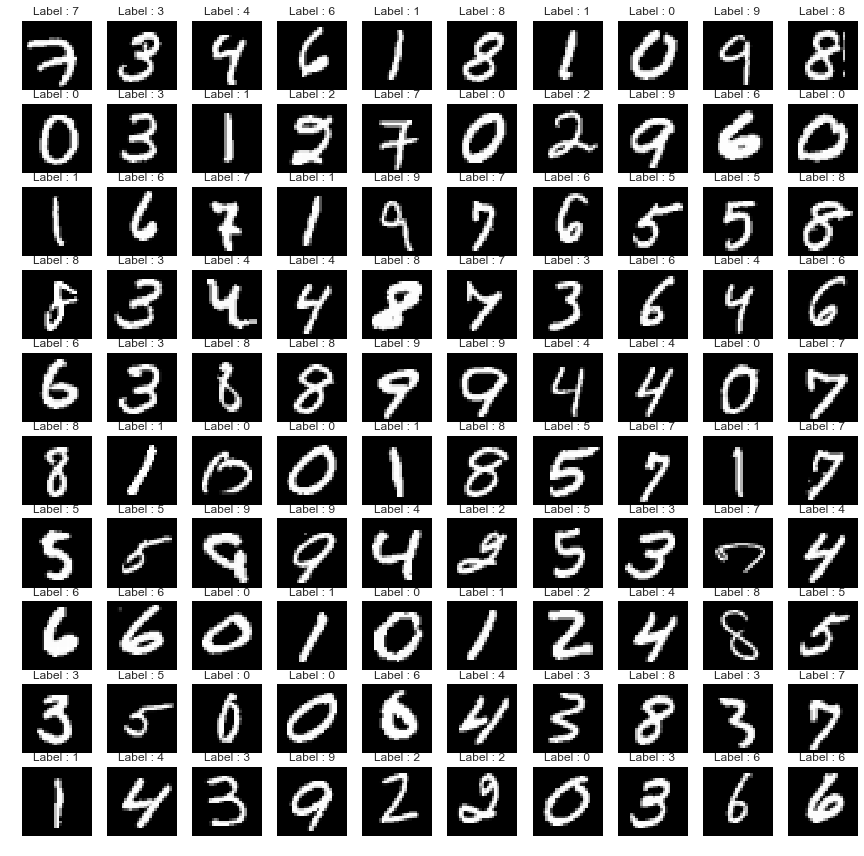

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [25]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x): return x

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0.0),tf.float32)

def tf_lrelu(x): return tf.nn.leaky_relu(x,alpha=0.85)
def d_tf_lrelu(x): return tf.cast(tf.greater(x,0),tf.float32) + tf.cast(tf.less_equal(x,0),tf.float32) * 0.85

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
            self.b = tf.Variable(tf.random_uniform(shape=(outc),     minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
            self.b = tf.Variable(tf.random_normal([outc],     stddev=0.05,seed=2,dtype=tf.float32))
        self.m,self.v     = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer) 
        return self.layerA

    def backprop(self,gradient=None,which_reg=0,learning_rate=0.0008):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===        
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w
            grad_b=grad_b + lamda * 2.0 * self.b

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []
        
        # Update the Weight First         
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
#         update_w.append(tf.assign(self.w,tf.subtract(self.w,learning_rate*grad )))
        
        # Update the Bias later
        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b )))  
#         update_w.append(tf.assign(self.b,tf.subtract(self.b,learning_rate*grad_b )))        
        
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [26]:
# hyper class
num_epoch = 101; batch_size = 100; print_size = 2
lamda = 0.0
beta1,beta2,adam_e = 0.1,0.111,1e-8

e1 = FNN(784,1000,  which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
e2 = FNN(1000,1000, which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
e3 = FNN(1000,2,    which_reg=0.0,act=tf_identiy,d_act=tf_identiy)

d1 = FNN(2,1000,    which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
d2 = FNN(1000,1000, which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
d3 = FNN(1000,784,  which_reg=0.0,act=tf_sigmoid,d_act=d_tf_sigmoid)

discrim1 = FNN(2,1000   ,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim2 = FNN(1000,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim3 = FNN(1000,1   ,which_reg=0.0,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [27]:
# encoding/decoding
x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
recon_learning_rate = tf.placeholder(shape=[],dtype=tf.float32)

elayer1 = e1.feedforward(x)
elayer2 = e2.feedforward(elayer1)
elayer3 = e3.feedforward(elayer2)

dlayer1 = d1.feedforward(elayer3)
dlayer2 = d2.feedforward(dlayer1)
dlayer3 = d3.feedforward(dlayer2)

recon_cost = tf.reduce_mean(tf.square(dlayer3-x))

total_grad = (dlayer3 - x)/batch_size

dgrad3,dgrad3_up = d3.backprop(total_grad,learning_rate=recon_learning_rate)
dgrad2,dgrad2_up = d2.backprop(dgrad3,learning_rate=recon_learning_rate)
dgrad1,dgrad1_up = d1.backprop(dgrad2,learning_rate=recon_learning_rate)

egrad3,egrad3_up = e3.backprop(dgrad1,learning_rate=recon_learning_rate)
egrad2,egrad2_up = e2.backprop(egrad3,learning_rate=recon_learning_rate)
egrad1,egrad1_up = e1.backprop(egrad2,learning_rate=recon_learning_rate)

grad_update = dgrad3_up + dgrad2_up + dgrad1_up + \
              egrad3_up + egrad2_up + egrad1_up 

print(elayer1,elayer2)
print(elayer3)
print(dlayer1,dlayer2)
print(dlayer3)

print(dgrad3)
print(dgrad2,dgrad1)
print(egrad3)
print(egrad2,egrad1)

Tensor("Relu_24:0", shape=(100, 1000), dtype=float32) Tensor("Relu_25:0", shape=(100, 1000), dtype=float32)
Tensor("add_62:0", shape=(100, 2), dtype=float32)
Tensor("Relu_26:0", shape=(100, 1000), dtype=float32) Tensor("Relu_27:0", shape=(100, 1000), dtype=float32)
Tensor("Sigmoid_18:0", shape=(100, 784), dtype=float32)
Tensor("MatMul_103:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_105:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_107:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_109:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_111:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_113:0", shape=(100, 784), dtype=float32)


In [28]:
# discriminator
dis_x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
dis_z = tf.placeholder(shape=[batch_size,2],dtype=tf.float32)
dis_learning_rate = tf.placeholder(shape=[],dtype=tf.float32)

dis_elayer1 = e1.feedforward(dis_x)
dis_elayer2 = e2.feedforward(dis_elayer1)
dis_elayer3 = e3.feedforward(dis_elayer2)

x_concat  = tf.concat([dis_elayer3,dis_z],axis=0)
dislayer1 = discrim1.feedforward(x_concat)
dislayer2 = discrim2.feedforward(dislayer1)
dislayer3 = discrim3.feedforward(dislayer2)

discrim_labels = tf.concat([
    tf.ones([batch_size,1]),tf.zeros([batch_size,1])
],axis=0)

discrim_cost = - tf.reduce_mean(
    discrim_labels * tf.log(dislayer3+10e-8) + (1-discrim_labels) * tf.log(1-dislayer3 + 10e-8)
)

dis_grad = (-(discrim_labels/(dislayer3 + 10e-8)) + ((1-discrim_labels)/(1-dislayer3 + 10e-8)))/batch_size

dis_disgrad3,dis_disgrad3_up = discrim3.backprop(dis_grad,learning_rate=dis_learning_rate)
dis_disgrad2,dis_disgrad2_up = discrim2.backprop(dis_disgrad3,learning_rate=dis_learning_rate)
dis_disgrad1,dis_disgrad1_up = discrim1.backprop(dis_disgrad2,learning_rate=dis_learning_rate)

dis_grad_update = dis_disgrad3_up + dis_disgrad2_up + dis_disgrad1_up

print(dis_elayer1,dis_elayer2)
print(dis_elayer3)

print(x_concat)
print(dislayer1,dislayer2)
print(dislayer3)

print(dis_grad)
print(dis_disgrad3)
print(dis_disgrad2,dis_disgrad1)

Tensor("Relu_28:0", shape=(100, 1000), dtype=float32) Tensor("Relu_29:0", shape=(100, 1000), dtype=float32)
Tensor("add_104:0", shape=(100, 2), dtype=float32)
Tensor("concat_4:0", shape=(200, 2), dtype=float32)
Tensor("Relu_30:0", shape=(200, 1000), dtype=float32) Tensor("Relu_31:0", shape=(200, 1000), dtype=float32)
Tensor("Sigmoid_21:0", shape=(200, 1), dtype=float32)
Tensor("truediv_89:0", shape=(200, 1), dtype=float32)
Tensor("MatMul_121:0", shape=(200, 1000), dtype=float32)
Tensor("MatMul_123:0", shape=(200, 1000), dtype=float32) Tensor("MatMul_125:0", shape=(200, 2), dtype=float32)


In [29]:
# generator 
fake_x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
fake_learning_rate = tf.placeholder(shape=[],dtype=tf.float32) 

fake_elayer1 = e1.feedforward(fake_x)
fake_elayer2 = e2.feedforward(fake_elayer1)
fake_elayer3 = e3.feedforward(fake_elayer2)

fake_dislayer1 = discrim1.feedforward(fake_elayer3)
fake_dislayer2 = discrim2.feedforward(fake_dislayer1)
fake_dislayer3 = discrim3.feedforward(fake_dislayer2)

fake_labels = tf.zeros([batch_size,1])

fake_cost = - tf.reduce_mean(
    fake_labels * tf.log(fake_dislayer3+10e-8) + (1-fake_labels) * tf.log(1-fake_dislayer3 + 10e-8)
)

fake_grad = (-(fake_labels/(fake_dislayer3 + 10e-8)) + ((1-fake_labels)/(1-fake_dislayer3 + 10e-8)))/batch_size

fake_disgrad3,_ = discrim3.backprop(fake_grad)
fake_disgrad2,_ = discrim2.backprop(fake_disgrad3)
fake_disgrad1,_ = discrim1.backprop(fake_disgrad2)

fake_egrad3,fake_egrad3_up = e3.backprop(fake_disgrad1,learning_rate=fake_learning_rate)
fake_egrad2,fake_egrad2_up = e2.backprop(fake_egrad3,learning_rate=fake_learning_rate)
fake_egrad1,fake_egrad1_up = e1.backprop(fake_egrad2,learning_rate=fake_learning_rate)

fake_grad_update = fake_egrad3_up + fake_egrad2_up + fake_egrad1_up

print(fake_elayer1,fake_elayer2)
print(fake_elayer3)
print(fake_dislayer1,fake_dislayer2)
print(fake_dislayer3)

print(fake_disgrad3)
print(fake_disgrad2,fake_disgrad1)
print(fake_egrad3)
print(fake_egrad2,fake_egrad1)

Tensor("Relu_32:0", shape=(100, 1000), dtype=float32) Tensor("Relu_33:0", shape=(100, 1000), dtype=float32)
Tensor("add_134:0", shape=(100, 2), dtype=float32)
Tensor("Relu_34:0", shape=(100, 1000), dtype=float32) Tensor("Relu_35:0", shape=(100, 1000), dtype=float32)
Tensor("Sigmoid_24:0", shape=(100, 1), dtype=float32)
Tensor("MatMul_133:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_135:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_137:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_139:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_141:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_143:0", shape=(100, 784), dtype=float32)


 iter: 0 batch: 4900 recon cost: 0.06447998 discrim cost: 0.68655014 fake cost: 0.709226851

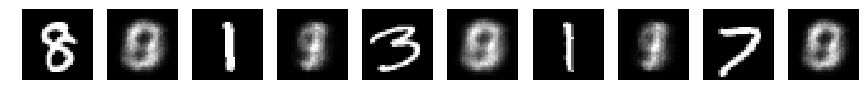

 iter: 2 batch: 4900 recon cost: 0.057219736 discrim cost: 0.27969018 fake cost: 1.7002206

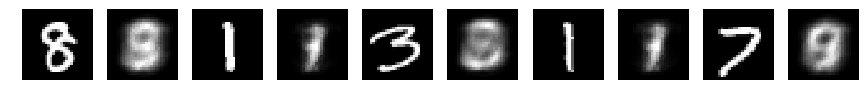

 iter: 4 batch: 4900 recon cost: 0.058051173 discrim cost: 0.2725921 fake cost: 1.76039238

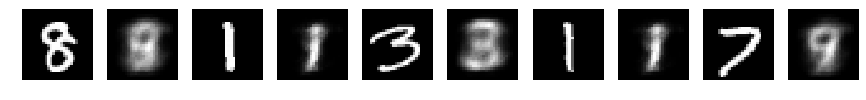

 iter: 6 batch: 4900 recon cost: 0.05562718 discrim cost: 0.31789926 fake cost: 1.66605218

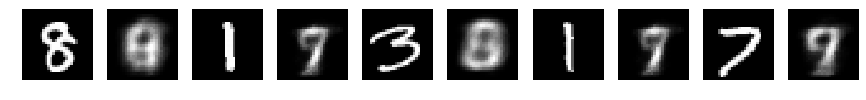

 iter: 8 batch: 4900 recon cost: 0.060160425 discrim cost: 0.27546477 fake cost: 1.6944344

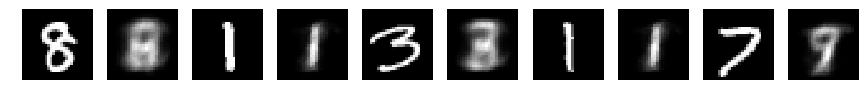

 iter: 10 batch: 4900 recon cost: 0.059220992 discrim cost: 0.28926334 fake cost: 1.6228977

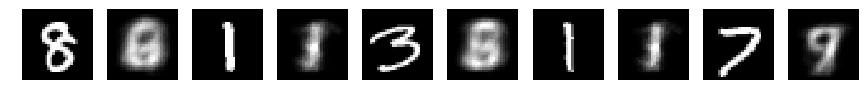

 iter: 12 batch: 4900 recon cost: 0.05845869 discrim cost: 0.2674256 fake cost: 1.646288322

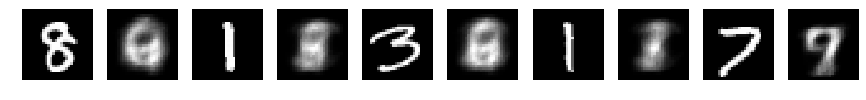

 iter: 14 batch: 4900 recon cost: 0.055179358 discrim cost: 0.28311783 fake cost: 1.9363792

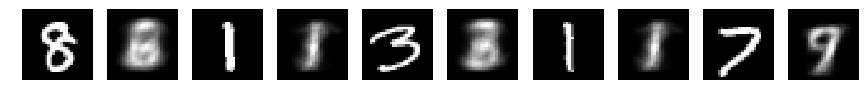

 iter: 16 batch: 4900 recon cost: 0.058677405 discrim cost: 0.26827043 fake cost: 2.0714767

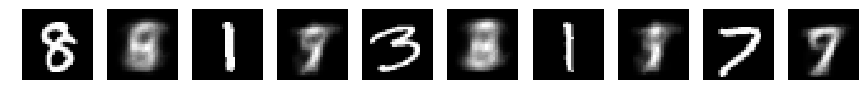

 iter: 18 batch: 4900 recon cost: 0.056198377 discrim cost: 0.2821631 fake cost: 1.94890217

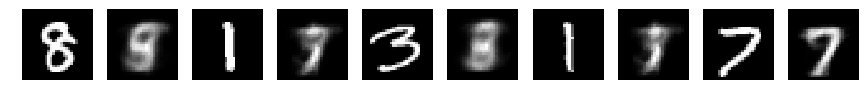

 iter: 20 batch: 4900 recon cost: 0.054492157 discrim cost: 0.29736373 fake cost: 2.0786798

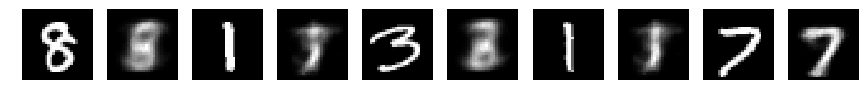

 iter: 22 batch: 4900 recon cost: 0.05572316 discrim cost: 0.2590027 fake cost: 2.170862561

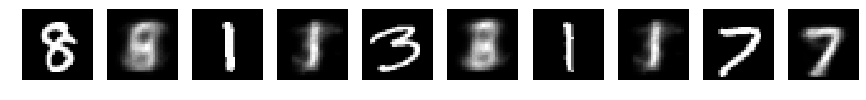

 iter: 24 batch: 4900 recon cost: 0.052433908 discrim cost: 0.2736708 fake cost: 1.57435564

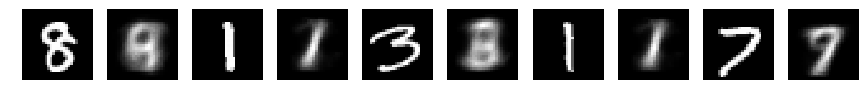

 iter: 26 batch: 4900 recon cost: 0.054719526 discrim cost: 0.2560084 fake cost: 1.63930429

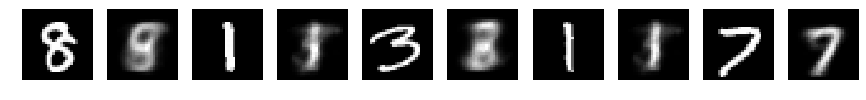

 iter: 28 batch: 4900 recon cost: 0.053746276 discrim cost: 0.23010848 fake cost: 2.0437784

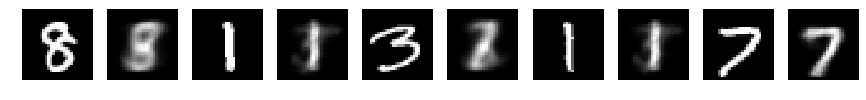

 iter: 30 batch: 4900 recon cost: 0.053533062 discrim cost: 0.26272714 fake cost: 1.7176979

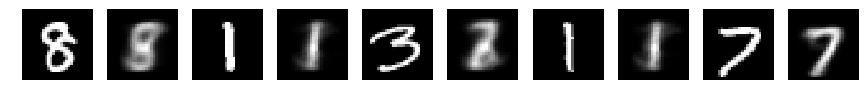

 iter: 32 batch: 4900 recon cost: 0.05347868 discrim cost: 0.2996328 fake cost: 1.646716735

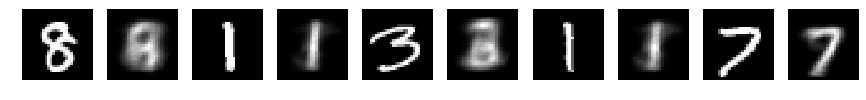

 iter: 34 batch: 4900 recon cost: 0.056595147 discrim cost: 0.24566066 fake cost: 2.6127381

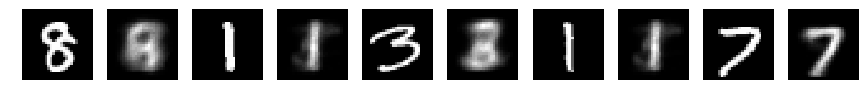

 iter: 36 batch: 4900 recon cost: 0.05194846 discrim cost: 0.26346052 fake cost: 2.63630687

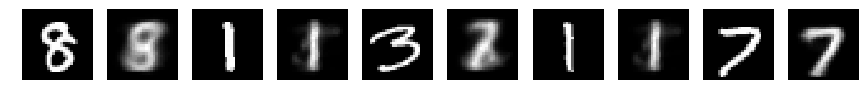

 iter: 38 batch: 4900 recon cost: 0.054989625 discrim cost: 0.27425006 fake cost: 2.5777511

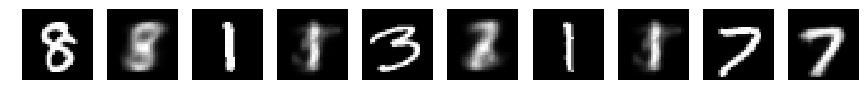

 iter: 40 batch: 4900 recon cost: 0.053320512 discrim cost: 0.2511399 fake cost: 1.72764736

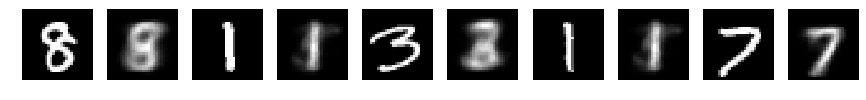

 iter: 42 batch: 4900 recon cost: 0.05265108 discrim cost: 0.2847036 fake cost: 1.719058329

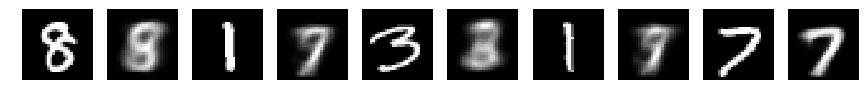

 iter: 44 batch: 4900 recon cost: 0.053196393 discrim cost: 0.27799466 fake cost: 1.8425059

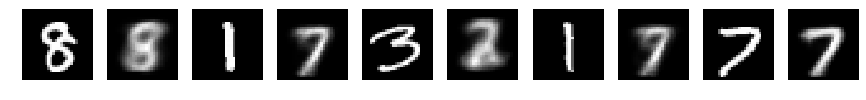

 iter: 46 batch: 4900 recon cost: 0.053802446 discrim cost: 0.2789506 fake cost: 1.56578764

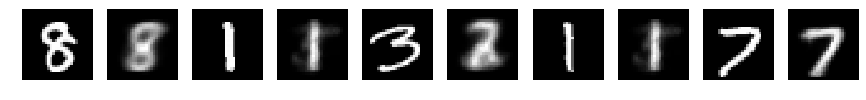

 iter: 48 batch: 4900 recon cost: 0.051803414 discrim cost: 0.277043 fake cost: 1.488681883

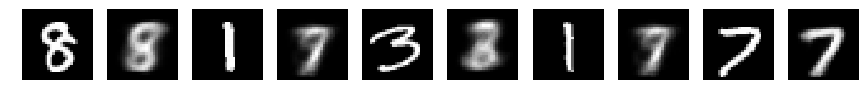

 iter: 50 batch: 4900 recon cost: 0.051381078 discrim cost: 0.27157262 fake cost: 1.6094713

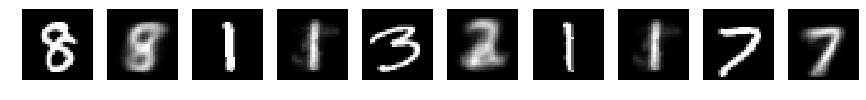

 iter: 52 batch: 4900 recon cost: 0.055106837 discrim cost: 0.26645887 fake cost: 1.6382273

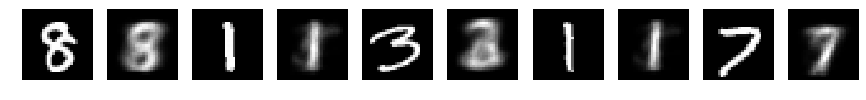

 iter: 54 batch: 4900 recon cost: 0.052507155 discrim cost: 0.44411105 fake cost: 2.9863324

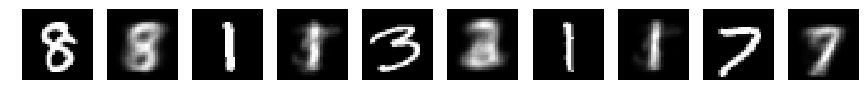

 iter: 56 batch: 4900 recon cost: 0.05233417 discrim cost: 0.3135272 fake cost: 3.537466851

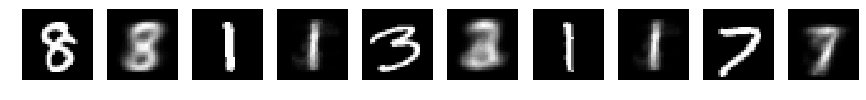

 iter: 58 batch: 4900 recon cost: 0.052737404 discrim cost: 0.71763945 fake cost: 3.2205715

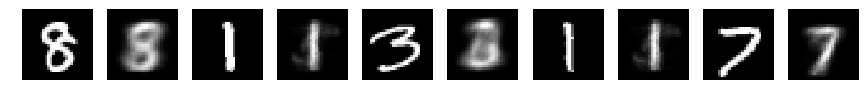

 iter: 60 batch: 4900 recon cost: 0.05393013 discrim cost: 0.28742686 fake cost: 2.96844469

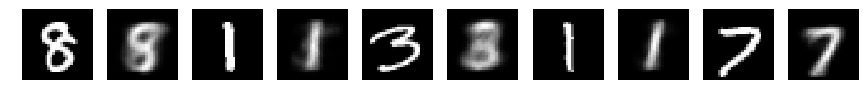

 iter: 62 batch: 4900 recon cost: 0.056451682 discrim cost: 0.2736116 fake cost: 3.01000864

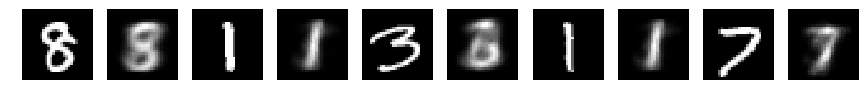

 iter: 64 batch: 4600 recon cost: 0.053785805 discrim cost: 0.25030962 fake cost: 2.8354633

In [ ]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()

prior_z = np.random.uniform(low=-2, high=2,size=(batch_size, 2)).astype(np.float32)

for iter in range(num_epoch):
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        
        sess_result1 = sess.run([recon_cost,grad_update],
                    feed_dict={x:current_data.reshape((batch_size,-1)),recon_learning_rate:0.0008})
        sess_result2 = sess.run([discrim_cost,dis_grad_update],
                    feed_dict={dis_x:current_data.reshape((batch_size,-1)),dis_z:prior_z,dis_learning_rate:0.0008})
        sess_result3 = sess.run([fake_cost,fake_grad_update],
                    feed_dict={fake_x:current_data.reshape((batch_size,-1)),fake_learning_rate:0.00008})
        
        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + \
            ' recon cost: ' + str(sess_result1[0]) + \
            ' discrim cost: ' + str(sess_result2[0]) + \
            ' fake cost: ' + str(sess_result3[0])

        )
        sys.stdout.flush()
        
    if iter % print_size == 0:
        sess_result = sess.run(dlayer3,feed_dict={x:current_data.reshape((batch_size,-1))}).reshape((batch_size,28,28))
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer3,feed_dict={x:train_batch[:batch_size].reshape((batch_size,-1))})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer3,feed_dict={x:current_train_data.reshape((batch_size,-1))})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()